In [148]:
import numpy as np
import pandas as pd
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [122]:
tf.__version__

'2.18.0-dev20240815'

1.0 Data collection

In [91]:
# paths to zipped files
plates_zipped_path = "/Users/godfreykrutzsch/Desktop/platesv2/plates.zip"
plates_images_path = "/Users/godfreykrutzsch/Desktop/platesv2/"

1.1 unzip file

In [92]:
# unzip file
with zipfile.ZipFile(plates_zipped_path, "r") as plates_zipped:
    plates_zipped.extractall(plates_images_path)
    plates_zipped.close()

1.2 Exploration

In [93]:
data_directory = "/Users/godfreykrutzsch/Desktop/platesv2/plates"
print(os.listdir(data_directory))

['.DS_Store', 'test', 'train']


In [94]:
# the "_," ignores labels
for directory, _, filename in os.walk(data_directory):
    for filename in filename:
        print(os.path.join(data_directory, filename))

/Users/godfreykrutzsch/Desktop/platesv2/plates/.DS_Store
/Users/godfreykrutzsch/Desktop/platesv2/plates/0071.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0717.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0703.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0065.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0059.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0515.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0273.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0267.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0501.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0529.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0298.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0461.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0307.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0313.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0475.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/0449.jpg
/Users/godfreykrutzsch/Desktop/platesv2/plates/

In [153]:
training_directory = data_directory + '/train'
testing_directory = data_directory + '/test'
print(os.listdir(training_directory))
# print(os.listdir(testing_directory))

['.DS_Store', 'cleaned', 'dirty']


In [85]:
# width & height images
image_size = (200,200)
# the number of images in each batch during training.
batch_size = 8

In [123]:
"""
tf pipeline used to load and preprocess images from a directory, for training in a neural network while storing them as tensors.
"""

# load images from local directory and create object for training. Images are automatically labelled based on directory name. Each sub-directory is a class label.
tf_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_directory,
    validation_split=0.3, # 30% data is for validation 70% for training.
    subset="training",
    seed=1307,
    image_size=image_size,
    batch_size=batch_size
)

tf_validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_directory,
    validation_split=0.3,
    subset="validation",
    seed=1307,
    image_size=image_size,
    batch_size=batch_size
)


Found 40 files belonging to 2 classes.
Using 28 files for training.
Found 40 files belonging to 2 classes.
Using 12 files for validation.


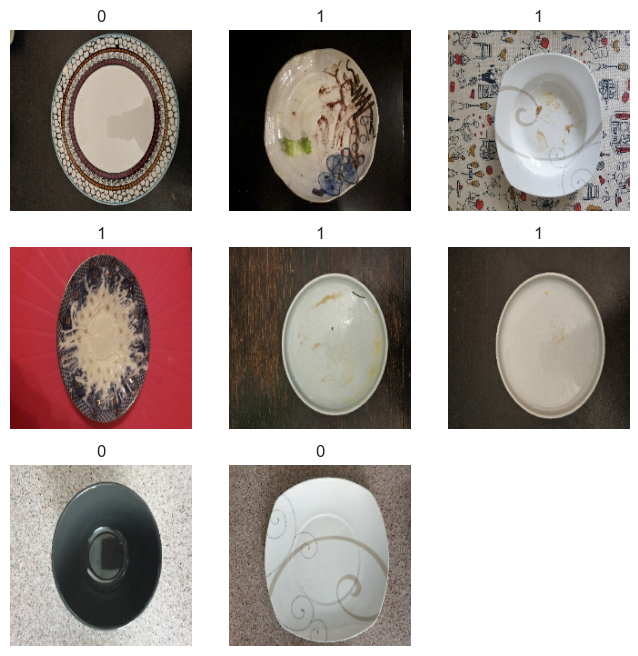

In [125]:
# visualise first 8 images from the first batch of a dataset, along with corresponding labels.
plt.figure(figsize=(8,8))
 
# take first batch from (TF_train_dataset) and loop once over this batch given take(1). i think these images and labels are stored as tensors, and each time matlib wants to show something it must be first converted to an integer.
for images, labels in tf_train_dataset.take(1):
    for i in range(8):
        
        # create sub-plot 3x3
        ax = plt.subplot(3, 3, i+1)
        # convert to int so matplotlib can show it, as train_dataset is a tf function
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [126]:
"""
This code is performing data augmentation, which is a technique used to artificially increase the size and diversity of a training dataset by applying various transformations to the input data. Specifically, in this case, the code is creating a sequence of image transformations that will be applied to each input image during the training process.
"""

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.45),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.4)
    
])

2024-08-30 09:39:18.452290: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(8, 200, 200, 3)


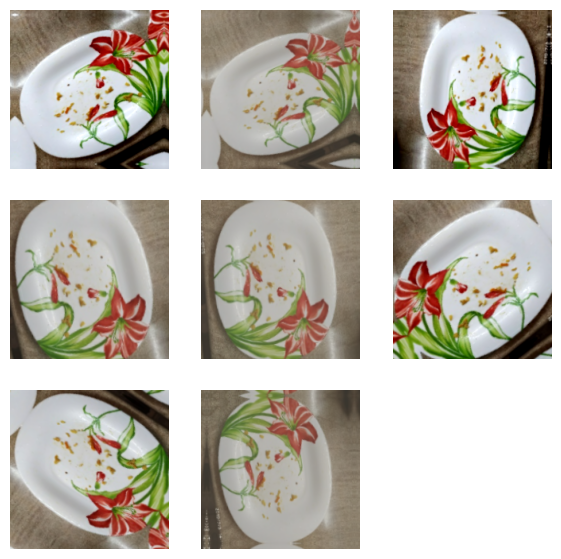

In [117]:
"""
This code snippet is generating and displaying a grid of augmented images using Matplotlib. The purpose is to visualize how the data augmentation transformations are being applied to a batch of images from a training dataset using a 3x3 grid and subplot of 7 inches. it applies the data augmentation to 1 image 9 times e.g. 9 different augmented versions of that image with a random element.
"""
plt.figure(figsize=(7,7)) # canvas on which images are displayed 10x 10 inches
for images, _ in tf_train_dataset.take(1): #just take first batch and _ ignores labels
    for i in range(8):
        # this batch is in the form of a tensor
        augmented_images = data_augmentation(images)
       
        ax = plt.subplot(3, 3, i+1)
        # convert the tensor to numpy and display, [0] accesses first image in batch that we augument 8 times
        # select first image from the batch that changes each time, of augmented images  and display this image with each iteration of the loop 
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
print(augmented_images.shape)  

In [127]:
"""
This code snippet is transforming a TensorFlow dataset (train_ds) by applying data augmentation to the images and then preparing the dataset for training by repeating and shuffling it.

The train_ds.map(...) operation produces a new dataset augmented_train_ds, where each image has been augmented according to the defined transformations.
"""
#tf_train_dataset has x images and y labels.
# map applies function to each element in the dataset.
# apply data-augmentation to image x and returns a tuple with augmented image and same unchanged label e.g. lots of dirty augmentations created

augmented_train_dataset = tf_train_dataset.map(lambda x,y: (data_augmentation(x, training=True), y)).repeat(300).shuffle(32)

"""
.repeat(300): This repeats the entire dataset 300 times. In practice, this means that after going through all the augmented images once, the dataset will start over and go through them again, repeating this process 300 times. Repeating the dataset is often used to ensure that the model sees each image multiple times during training, which can be useful when the dataset is small or when you want to train for many epochs.

shuffle is key in training  to prevent model from learning the order of data which could lead to overfitting
"""

'\n.repeat(300): This repeats the entire dataset 300 times. In practice, this means that after going through all the augmented images once, the dataset will start over and go through them again, repeating this process 300 times. Repeating the dataset is often used to ensure that the model sees each image multiple times during training, which can be useful when the dataset is small or when you want to train for many epochs.\n\nshuffle is key in training  to prevent model from learning the order of data which could lead to overfitting\n'

In [128]:
augmented_train_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [129]:
tf_train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [130]:
"""
Prefetching is a technique that allows the data pipeline to fetch batches of data in the background while the model is training on the current batch.
"""
#buffer size means there are 32 batches preloaded and ready to be fed into the model, which reduce time model spends waiting for data.
tf_train_dataset = tf_train_dataset.prefetch(buffer_size=32)
tf_validation_dataset = tf_validation_dataset.prefetch(buffer_size=32)

In [120]:
""" Parameters:

input_shape: Specifies the shape of the input images, e.g., (height, width, channels).
num_classes: The number of output classes for classification (e.g., 2 for binary classification)."""

def make_model(input_shape, num_classes):
    
# INPUT LAYER

    inputs = keras.Input(shape=input_shape)

# IMAGE AUGMENTATION BLOCK

    # increase the size of the variability of the training set
    x = data_augmentation(inputs)
    
# ENTRY BLOCK prepare input data for more processing by applying convolutional layers, batch norm and activation functions
    
    x = layers.Rescaling(1./255)(x)
    # applies 2d convolutional layer with 32 filters and 3x3 
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
# normalize outputs of convolutional layers to stabilize & accelerate training
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # apply another layer with 64 filters
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # stores the output of previous block to use as residual


# This block of code is part of a loop that builds multiple RESIDUAL BLOCKS within a convolutional neural network (CNN). The loop iterates over a list of sizes [128, 256, 512, 728], where each size represents the number of filters used in the convolutional layers of that block.
    
# Residual blocks are the key components of ResNet (Residual Network) architectures, which have become highly influential in computer vision tasks. ResNets can be constructed with many layers (e.g., ResNet-50, ResNet-101), thanks to the use of residual blocks.
    
# A residual block is a building block in deep CNNs that helps to stabilize training and improve performance by learning residual functions. It allows deep networks to be trained effectively by adding skip connections that help preserve the input and reduce the difficulty of learning complex transformations.

# RESIDUAL BLOCK

    for size in [128, 256, 512, 718]:
        x = layers.Activation("relu")(x)
        
        # The for loop in the code iterates over the list [128, 256, 512, 728], where each value corresponds to a different number of filters used in the convolutional layers within that iteration.
        # First Iteration (size = 128):
        # The loop starts with size set to 128. The model applies a block of operations (two separable convolutions, batch normalization, ReLU activation, and max pooling) with 128 filters. Then the second iteration is 256. Note: Separable convolutions are more computationally efficient than standard convolutions.
        
        
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # normalize outputs of convolutional layers to stabilize & accelerate training
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
         # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

# FINAL CONVOLUTIONAL BLOCK

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

# OUTPUT LAYER 

# Activation Function:
# If the model is for binary classification (num_classes == 2) e.g. clear or dirty, the activation will be "sigmoid", which outputs a probability score between 0 and 1.
# If the model is for multi-class classification, the activation will be "softmax", which outputs a probability distribution across the classes. this code is not really required as when we call the function make_model we define it is a binary classification model.

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    #regularization technique stops overfitting
    x = layers.Dropout(0.5)(x)
    #output layer where each neuron is connected to every neuron in previous layer
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# make instance of neural network, pass image, 3(RGB) and 2 (for binary classification)
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()
keras.utils.plot_model(model, show_shapes=True)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 200, 200,  │          0 │ input_layer_9[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 200, 200,  │          0 │ sequential_3[2][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 100, 100,  │        896 │ rescaling_4[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_44       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 100, 100,  │     18,496 │ activation_44[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 100, 100,  │          0 │ activation_45[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_36 │ (None, 100, 100,  │      8,896 │ activation_46[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_37 │ (None, 100, 100,  │     17,664 │ activation_47[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 50, 50,    │      8,320 │ activation_45[0]

 Total params: 2,747,419 (10.48 MB)

 Trainable params: 2,738,723 (10.45 MB)

 Non-trainable params: 8,696 (33.97 KB)

In [134]:
# epoch is one full cycle through the entire training set.
# if you have 10,000 images with a batch size of 100 it would take (10,000/100) 100 batches to complete one epoch
epochs = 5

"""
Purpose: This callback saves the model after every epoch or when certain conditions are met (e.g., the best model based on validation loss),  (e.g., save_at_1.keras, save_at_2.keras, etc.). This is useful for saving checkpoints during training so you can later load the best-performing model or continue training from a specific epoch

This callback stops training early if the model's performance on the validation set stops improving. It is particularly useful for preventing overfitting.

* monitor='val_loss': The training process will monitor the validation loss to determine when to stop.
* patience=10: The training will stop if there is no improvement in validation loss for 10 consecutive epochs.
* restore_best_weights=True (optional): This option can be set to restore the model weights from the epoch with the best validation loss, ensuring that you end up with the best model, not just the last one before stopping

"""

model_cp = keras.callbacks.ModelCheckpoint(f"save_at_{epochs}.keras")
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [135]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [136]:
history = model.fit(
    augmented_train_dataset, epochs=epochs, callbacks=[model_cp, earlystop], validation_data=tf_validation_dataset
)

Epoch 1/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 442s 364ms/step - accuracy: 0.7419 - loss: 0.5137 - val_accuracy: 0.5833 - val_loss: 1.6063
Epoch 2/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 421s 350ms/step - accuracy: 0.9405 - loss: 0.1650 - val_accuracy: 0.5000 - val_loss: 1.3434
Epoch 3/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 421s 350ms/step - accuracy: 0.9744 - loss: 0.0827 - val_accuracy: 0.6667 - val_loss: 1.8437
Epoch 4/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 394s 328ms/step - accuracy: 0.9781 - loss: 0.0755 - val_accuracy: 0.5000 - val_loss: 1.7776
Epoch 5/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.9738 - loss: 0.0772 - val_accuracy: 0.8333 - val_loss: 2.2603


In [ ]:
""" 
the history object of each epoch that is returned after the fit() function in keras

{
    'loss': [0.693, 0.588, 0.492, ...],  # Loss values for each epoch
    'accuracy': [0.50, 0.75, 0.80, ...], # Accuracy values for each epoch
    'val_loss': [0.683, 0.592, 0.495, ...], # Validation loss values for each epoch
    'val_accuracy': [0.52, 0.73, 0.78, ...]  # Validation accuracy for each epoch
}

"""


In [145]:
def plot_history(history, epochs):
    
    # the syntax is name of model (history), . history object (history.loss, accuracy, val_loss or val acc)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # epochs_range = range(epochs+1)
    epochs_range = range(1, len(acc)+1)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()
    

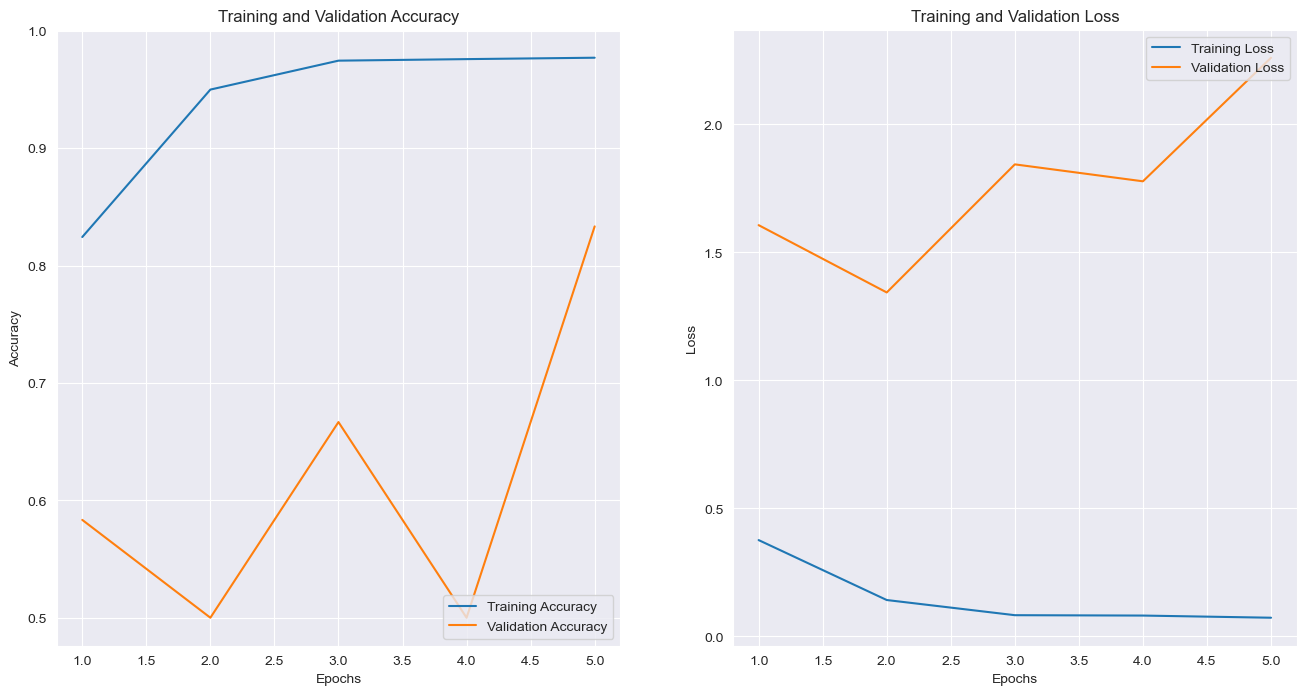

In [146]:
plot_history(history, earlystop.stopped_epoch)

In [201]:
# this model works where a directory has a sub-director (e.g ...plates/train then the images. If you do not have a sub-directory e.g. say in test directory you must go one step back to parent (plates) and add field classes=['test'] then Imagedataclass can find the images otherwise you get Found 0 belonging to 0 classes.

test_datagen = ImageDataGenerator()

# this lets you load batches of images from a labeled directory structure, where the name of each sub dir is class name in a classification task e.g. dog and cats or clean and dirty.

test_generator = test_datagen.flow_from_directory(
    directory= '/Users/godfreykrutzsch/Desktop/platesv2/plates/',
    classes= ['test'],
    target_size=(200,200),
    batch_size=1,
    shuffle=False,
    class_mode=None, 
     )

Found 744 images belonging to 1 classes.


In [198]:
# 744 test images found when i ignore labels.
directory = '/Users/godfreykrutzsch/Desktop/platesv2/plates/test/'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory,
    labels=None,  # No labels if you don't have subdirectories for classes
    label_mode=None,
    batch_size=32,
    image_size=(200, 200),
    shuffle=False  # No need to shuffle if labels aren't being used
)

Found 744 files.


In [208]:
test_generator.reset() 
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
len(predictions)
# predict = model.predict(dataset)

744/744 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step


744

In [206]:
predictions[:100]

array([[0.9999985 ],
       [0.9999993 ],
       [0.9999901 ],
       [0.99999225],
       [0.9999963 ],
       [0.99999964],
       [0.99754214],
       [0.9999893 ],
       [0.9999986 ],
       [0.99970746],
       [0.9999907 ],
       [0.9999822 ],
       [0.9469126 ],
       [0.99999475],
       [0.22876792],
       [0.9999355 ],
       [0.9999146 ],
       [0.999976  ],
       [0.9999995 ],
       [0.999879  ],
       [0.9999993 ],
       [0.99997896],
       [1.        ],
       [0.9992952 ],
       [0.9321967 ],
       [0.99994105],
       [0.9994516 ],
       [0.28656387],
       [0.9998669 ],
       [0.9999997 ],
       [0.99944514],
       [0.9985722 ],
       [0.9999989 ],
       [0.9999959 ],
       [0.99999833],
       [0.9999999 ],
       [0.98690146],
       [0.99999976],
       [0.99999845],
       [0.99999595],
       [0.99999994],
       [0.99999774],
       [0.9999957 ],
       [0.9999857 ],
       [0.99925625],
       [0.9999921 ],
       [0.9999794 ],
       [0.999

In [207]:
sub_df = pd.DataFrame(predict)
sub_df['label'] = predict
sub_df['label'] = sub_df['label'].apply(lambda x : 'dirty' if x > 0.5 else 'cleaned')
sub_df.head()


,0,label
0,0.999997,dirty
1,0.999999,dirty
2,0.999998,dirty
3,0.999986,dirty
4,0.999995,dirty


In [188]:
sub_df.label.value_counts()

label
dirty      691
cleaned     53
Name: count, dtype: int64

In [195]:
submission_df = pd.DataFrame({'id': ids, 'label': predict})
submission_df

NameError: name 'ids' is not defined

In [190]:
sub_df.to_csv('/Users/godfreykrutzsch/Desktop/platesv2/sub_df.csv', index=False)